In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [3]:
# CORPUS_DIR = "convokit/thread_generator/fake-corpus-trajectory"
CORPUS_DIR = "convokit/thread_generator/annotated-fake-trajectory-4"
# CORPUS_DIR = 'convokit/tensor_decomposer/experiments/reddit-trajectory-subset-annotated'
# CORPUS_DIR = "convokit/tensor_decomposer/experiments/reddit-trajectory-subset"

In [4]:
from convokit import TensorDecomposer, HyperConvo, Corpus

In [5]:
corpus = Corpus(filename=CORPUS_DIR)

In [6]:
# hyperconv_range = range(2, 20+1)

In [7]:
# hyperconv_range = range(2, 20+1)
# def multi_hyperconv_transform(corpus, hyperconv_range):
#     hc_transformers = [HyperConvo(prefix_len=i, feat_name="hyperconvo-{}".format(i)) for i in hyperconv_range]
#     for idx, hc in enumerate(list(reversed(hc_transformers))):
#         print(hyperconv_range[-1]-idx)
#         hc.transform(corpus)

In [8]:
# multi_hyperconv_transform(corpus, hyperconv_range)

In [9]:
# corpus.dump("reddit-trajectory-subset-annotated", base_path="convokit/tensor_decomposer/experiments")

In [10]:
GROUP_SIZE=1500

In [11]:
import numpy as np
def _min_max_scale(mat):
    max_ = np.max(mat)
    min_ = np.min(mat)
    return (mat - min_) / (max_ - min_)

def minmax_normalize(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = _min_max_scale(tensor[:, :, i])
    return tensor

In [12]:
hyperconv_range = range(2, 20+1)
td = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3
                     )

In [13]:
td.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [14]:
# td.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_normal', 
#              report_title="25 May (normal)")

In [15]:
score = td.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.9848888888888889


## Standard (from 3)

In [16]:
td_3 = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 20+1)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3
                     )

In [17]:
td_3.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [18]:
td_3.tensor.shape

(18, 4500, 140)

In [19]:
score = td_3.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.9848888888888889


## Min-max normalized (across threads)

### From 2

In [20]:
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )

In [21]:
td_min_max.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [22]:
# td_min_max.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_minmax', 
#              report_title="25 May (min_max)")

In [23]:
score = td_min_max.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.688


### From 3

In [24]:
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )
td_min_max.fit(corpus)
td_min_max.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...Done.


0.7771111111111111

## Standard-scaled (across threads)

In [25]:
from sklearn.preprocessing import StandardScaler
def standard_scale(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = StandardScaler().fit_transform(tensor[:, :, i])
    return tensor

### From 2

In [26]:
td_std_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=standard_scale,
                      rank=3
                     )

In [27]:
td_std_scale.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [28]:
# td_std_scale.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_std_scl', 
#              report_title="25 May (std scale)")

In [29]:
score = td_std_scale.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.9606666666666667


### From 3

In [30]:
td_std_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=standard_scale,
                      rank=3
                     )
td_std_scale.fit(corpus)
td_std_scale.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...Done.


0.8366666666666667

## Min-max scaled (within thread)

In [31]:
def _min_max_within(mat):
    for i in range(mat.shape[1]):
        min_ = np.min(mat[:, i])
        max_ = np.max(mat[:, i])
        if max_ - min_ == 0:
            mat[:, i] = 0
        else:
            mat[:, i] = (mat[:, i] - min_)/ (max_ - min_)
    return mat

def minmax_within(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[1]):
        tensor[:, i, :] = _min_max_within(tensor[:, i, :])
    return tensor

### From 2

In [32]:
td_min_max_within = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_within,
                      rank=3
                     )

In [33]:
td_min_max_within.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


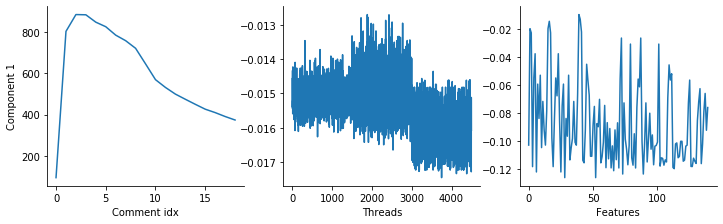

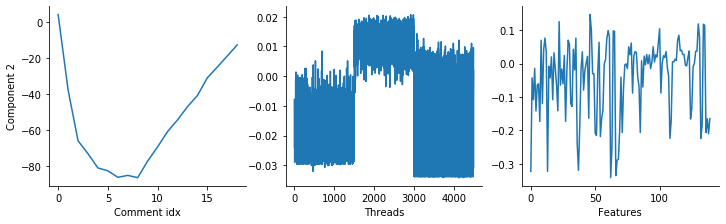

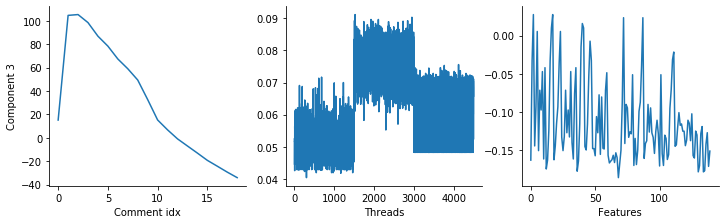

In [34]:
td_min_max_within.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
             output_dir='convokit/tensor_decomposer/reports/25May_minmax_within', 
             report_title="25 May (min max within)")

In [35]:
score = td_min_max_within.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.6571111111111111


### From 3

In [36]:
td_min_max_within = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_within,
                      rank=3
                     )

In [37]:
td_min_max_within.fit(corpus)
td_min_max_within.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...Done.


0.7806666666666666

## Standard scaling by comment index

In [38]:
from sklearn.preprocessing import scale

In [39]:
td.tensor[18, :, :]

array([[11.        ,  0.        ,  0.57894737, ...,  0.        ,
         0.        ,  0.        ],
       [10.        ,  0.        ,  0.52631579, ...,  0.        ,
         1.        ,  1.        ],
       [12.        ,  0.        ,  0.63157895, ...,  1.        ,
         1.        ,  3.        ],
       ...,
       [ 2.        ,  0.        ,  0.10526316, ...,  1.        ,
         1.        ,  1.        ],
       [ 2.        ,  7.        ,  0.10526316, ...,  3.        ,
         1.        ,  3.        ],
       [ 3.        ,  0.        ,  0.15789474, ...,  2.        ,
         1.        ,  2.        ]])

In [40]:
def scale_by_comment_idx(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[0]):
        tensor[0, :, :] = scale(tensor[0, :, :])
    return tensor

### From 2

In [41]:
td_idx_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=scale_by_comment_idx,
                      rank=3
                     )

In [42]:
td_idx_scale.fit(corpus)
td_idx_scale.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...Done.


0.9848888888888889

### From 3

In [43]:
td_idx_scale_3 = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=scale_by_comment_idx,
                      rank=3
                     )

In [44]:
td_idx_scale_3.fit(corpus)
td_idx_scale_3.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Decomposing tensor...Done.


0.9848888888888889

In [48]:
import pandas as pd
df = corpus.view_conversations()
df_subset = df[['meta.group', 'meta.hyperconvo-20']]
hc_dicts = {df_subset.iloc[idx].name: df_subset.iloc[idx]['meta.hyperconvo-20'] for idx in range(len(df_subset))}
df_hc = pd.DataFrame(hc_dicts).T.astype('float64')
df_combi = pd.concat([df_subset, df_hc], axis=1, sort=False)

In [92]:
df_combi

,meta.group,meta.hyperconvo-20,2nd-argmax[indegree over C->C mid-thread responses],2nd-argmax[indegree over C->C responses],2nd-argmax[indegree over C->c mid-thread responses],2nd-argmax[indegree over C->c responses],2nd-argmax[indegree over c->c mid-thread responses],2nd-argmax[indegree over c->c responses],2nd-argmax[outdegree over C->C mid-thread responses],2nd-argmax[outdegree over C->C responses],...,prop-nonzero[indegree over C->C mid-thread responses],prop-nonzero[indegree over C->C responses],prop-nonzero[indegree over C->c mid-thread responses],prop-nonzero[indegree over C->c responses],prop-nonzero[indegree over c->c mid-thread responses],prop-nonzero[indegree over c->c responses],prop-nonzero[outdegree over C->C mid-thread responses],prop-nonzero[outdegree over C->C responses],prop-nonzero[outdegree over C->c mid-thread responses],prop-nonzero[outdegree over C->c responses]
id,,,,,,,,,,,,,,,,,,,,,
1-1,1,"{'max[indegree over c->c responses]': 11, 'arg...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,...,0.333333,0.333333,0.421053,0.45,0.421053,0.45,0.333333,1.000000,0.333333,1.000000
2-1,1,"{'max[indegree over c->c responses]': 10, 'arg...",1.0,1.0,7.0,1.0,7.0,1.0,1.0,0.0,...,0.272727,0.272727,0.473684,0.50,0.473684,0.50,0.181818,1.000000,0.181818,1.000000
3-1,1,"{'max[indegree over c->c responses]': 12, 'arg...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,...,0.384615,0.384615,0.368421,0.40,0.368421,0.40,0.307692,1.000000,0.307692,1.000000
4-1,1,"{'max[indegree over c->c responses]': 10, 'arg...",1.0,1.0,7.0,1.0,7.0,1.0,1.0,0.0,...,0.272727,0.272727,0.473684,0.50,0.473684,0.50,0.181818,1.000000,0.181818,1.000000
5-1,1,"{'max[indegree over c->c responses]': 10, 'arg...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.454545,0.454545,0.473684,0.50,0.473684,0.50,0.272727,1.000000,0.272727,1.000000
6-1,1,"{'max[indegree over c->c responses]': 10, 'arg...",0.0,1.0,0.0,6.0,0.0,6.0,1.0,1.0,...,0.181818,0.181818,0.421053,0.45,0.421053,0.45,0.272727,1.000000,0.272727,1.000000
7-1,1,"{'max[indegree over c->c responses]': 9, 'argm...",3.0,1.0,0.0,12.0,0.0,12.0,1.0,1.0,...,0.500000,0.500000,0.473684,0.50,0.473684,0.50,0.500000,1.000000,0.500000,1.000000
8-1,1,"{'max[indegree over c->c responses]': 9, 'argm...",0.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0,...,0.600000,0.600000,0.526316,0.55,0.526316,0.55,0.500000,1.000000,0.500000,1.000000
9-1,1,"{'max[indegree over c->c responses]': 12, 'arg...",1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,...,0.333333,0.384615,0.368421,0.40,0.368421,0.40,0.250000,0.923077,0.250000,0.923077


In [94]:
import os

In [97]:
means = df_combi.groupby('meta.group').mean() #.to_csv('~/Desktop/agg_means.csv')

In [113]:
pd.set_option("display.max_columns", None)

In [114]:
means

,2nd-argmax[indegree over C->C mid-thread responses],2nd-argmax[indegree over C->C responses],2nd-argmax[indegree over C->c mid-thread responses],2nd-argmax[indegree over C->c responses],2nd-argmax[indegree over c->c mid-thread responses],2nd-argmax[indegree over c->c responses],2nd-argmax[outdegree over C->C mid-thread responses],2nd-argmax[outdegree over C->C responses],2nd-argmax[outdegree over C->c mid-thread responses],2nd-argmax[outdegree over C->c responses],2nd-largest / max[indegree over C->C mid-thread responses],2nd-largest / max[indegree over C->C responses],2nd-largest / max[indegree over C->c mid-thread responses],2nd-largest / max[indegree over C->c responses],2nd-largest / max[indegree over c->c mid-thread responses],2nd-largest / max[indegree over c->c responses],2nd-largest / max[outdegree over C->C mid-thread responses],2nd-largest / max[outdegree over C->C responses],2nd-largest / max[outdegree over C->c mid-thread responses],2nd-largest / max[outdegree over C->c responses],2nd-largest[indegree over C->C mid-thread responses],2nd-largest[indegree over C->C responses],2nd-largest[indegree over C->c mid-thread responses],2nd-largest[indegree over C->c responses],2nd-largest[indegree over c->c mid-thread responses],2nd-largest[indegree over c->c responses],2nd-largest[outdegree over C->C mid-thread responses],2nd-largest[outdegree over C->C responses],2nd-largest[outdegree over C->c mid-thread responses],2nd-largest[outdegree over C->c responses],argmax[indegree over C->C mid-thread responses],argmax[indegree over C->C responses],argmax[indegree over C->c mid-thread responses],argmax[indegree over C->c responses],argmax[indegree over c->c mid-thread responses],argmax[indegree over c->c responses],argmax[outdegree over C->C mid-thread responses],argmax[outdegree over C->C responses],argmax[outdegree over C->c mid-thread responses],argmax[outdegree over C->c responses],count[dyadic interaction motif over mid-thread],count[dyadic interaction motif],count[external reciprocity motif over mid-thread],count[external reciprocity motif],count[incoming triads over mid-thread],count[incoming triads],count[outgoing triads over mid-thread],count[outgoing triads],count[reciprocity motif over mid-thread],count[reciprocity motif],entropy[indegree over C->C mid-thread responses],entropy[indegree over C->C responses],entropy[indegree over C->c mid-thread responses],entropy[indegree over C->c responses],entropy[indegree over c->c mid-thread responses],entropy[indegree over c->c responses],entropy[outdegree over C->C mid-thread responses],entropy[outdegree over C->C responses],entropy[outdegree over C->c mid-thread responses],entropy[outdegree over C->c responses],is-present[dyadic interaction motif over mid-thread],is-present[dyadic interaction motif],is-present[external reciprocity motif over mid-thread],is-present[external reciprocity motif],is-present[incoming triads over mid-thread],is-present[incoming triads],is-present[outgoing triads over mid-thread],is-present[outgoing triads],is-present[reciprocity motif over mid-thread],is-present[reciprocity motif],max[indegree over C->C mid-thread responses],max[indegree over C->C responses],max[indegree over C->c mid-thread responses],max[indegree over C->c responses],max[indegree over c->c mid-thread responses],max[indegree over c->c responses],max[outdegree over C->C mid-thread responses],max[outdegree over C->C responses],max[outdegree over C->c mid-thread responses],max[outdegree over C->c responses],mean-nonzero[indegree over C->C mid-thread responses],mean-nonzero[indegree over C->C responses],mean-nonzero[indegree over C->c mid-thread responses],mean-nonzero[indegree over C->c responses],mean-nonzero[indegree over c->c mid-thread responses],mean-nonzero[indegree over c->c responses],mean-nonzero[outdegree over C->C mid-thread responses],mean-nonzero[outdegree over C->C responses],mean-nonzero[outdegree over C->c mid-thread responses],mean-nonzero[outdegree over C->c responses

In [102]:
percent_diff = abs(means.iloc[0] - means.iloc[1])*2 / (means.iloc[0] + means.iloc[1])

In [109]:
pd.set_option("display.max_rows", None)

In [111]:
percent_diff.sort_values().to_csv('~/Desktop/agg_means_pct_diff.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [59]:
df_subset.iloc[0].name

'1-1'